In [1]:
import pandas as pd
import numpy as np

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Data Preprocessing

We use the English-French translation data downloaded last week.

In [11]:
cleaned_en = pd.read_pickle('../wk14/data/cleaned_en.pkl')
cleaned_fr = pd.read_pickle('../wk14/data/cleaned_fr.pkl')

en_fr = pd.DataFrame({'en': cleaned_en, 'fr': cleaned_fr})
en_fr

,en,fr
0,resumption of the session,reprise de la session
1,i declare resumed the session of the european ...,je declare reprise la session du parlement eur...
2,although as you will have seen the dreaded mil...,comme vous avez pu le constater le grand bogue...
3,you have requested a debate on this subject in...,vous avez souhaite un debat a ce sujet dans le...
4,in the meantime i should like to observe a min...,en attendant je souhaiterais comme un certain ...
...,...,...
2007718,i would also like although they are absent to ...,je me permettrai meme bien quils soient absent...
2007719,i am not going to reopen the millennium or not...,je ne rouvrirai pas le debat sur le millenaire...
2007720,adjournment of the session,interruption de la session
2007721,i declare the session of the european parliame...,je declare interrompue la session du parlement...


In [12]:
((en_fr['en'].apply(len) < 1) | (en_fr['fr'].apply(len) < 1)).value_counts()

False    1998086
True        9637
dtype: int64

In [13]:
en_fr.drop(en_fr[(en_fr['en'].apply(len) < 1) | (en_fr['fr'].apply(len) < 1)].index, inplace=True)
((en_fr['en'].apply(len) < 1) | (en_fr['fr'].apply(len) < 1)).value_counts()

False    1998086
dtype: int64

In [14]:
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
fr_tokenizer = get_tokenizer('spacy', language='fr_core_news_sm')

2023-02-26 15:53:24.940606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 15:53:25.007547: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-26 15:53:25.369061: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bluesun/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/home/

In [26]:
import pickle
from sklearn.model_selection import train_test_split

def train_valid_test_split(df, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=None, shuffle=True):
    """
    Split the dataset into train, valid, and test set.
    """
    if shuffle is True:
        df = df.sample(frac=1, random_state=random_state)
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    train_df, valid_df = train_test_split(train_df, test_size=valid_size/(train_size+valid_size), random_state=random_state)
    return train_df, valid_df, test_df


def build_vocab(df, tokenizer, specials=['<unk>', '<pad>', '<bos>', '<eos>'], min_freq=2):
    """
    Build vocabulary from the dataset.
    :param specials:
        - <unk>: unknown token
        - <pad>: padding token
        - <bos>: beginning of sentence token
        - <eos>: end of sentence token
    :param min_freq: minimum frequency of the token to be included in the vocabulary.
    :return:
    """
    vocab = build_vocab_from_iterator(map(tokenizer, df), specials=specials, min_freq=min_freq)
    vocab.set_default_index(vocab['<unk>'])
    return vocab


def save_data(data, path):
    with open(path, 'wb') as f:
        pickle.dump(data, f)
        print(f'Data saved to {path}')

### Data sampling

It is difficult to use all of this data due to memory space issues.
Therefore, we will sample sentences that are not too long.

In [15]:
en_num_words = en_fr['en'].apply(lambda x: len(x.split()))
fr_num_words = en_fr['fr'].apply(lambda x: len(x.split()))

count    1.998086e+06
mean     2.486118e+01
std      1.481378e+01
min      1.000000e+00
25%      1.400000e+01
50%      2.200000e+01
75%      3.200000e+01
max      6.420000e+02
Name: en, dtype: float64


<Axes: ylabel='Frequency'>

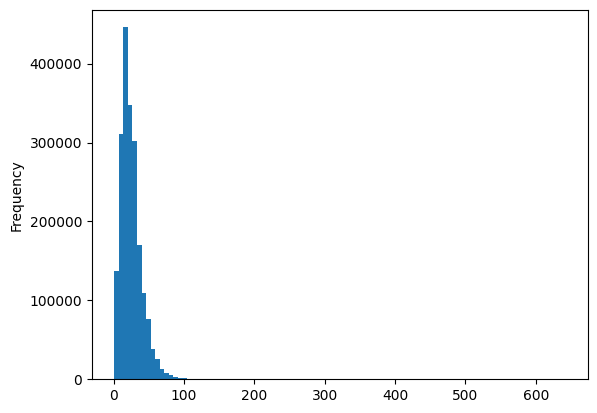

In [16]:
# inspect the distribution of the number of words in the sentences
print(en_num_words.describe())
en_num_words.plot(kind='hist', bins=100)

count    1.998086e+06
mean     2.596837e+01
std      1.558182e+01
min      1.000000e+00
25%      1.500000e+01
50%      2.300000e+01
75%      3.400000e+01
max      5.980000e+02
Name: fr, dtype: float64


<Axes: ylabel='Frequency'>

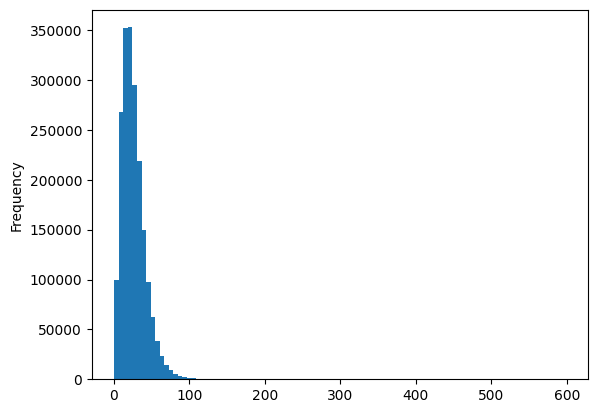

In [17]:
print(fr_num_words.describe())
fr_num_words.plot(kind='hist', bins=100)

In [20]:
en_num_words[en_num_words < 10].value_counts()

9    46413
8    44017
7    36911
6    32466
5    25211
4    22811
3     9418
1     5471
2     5455
Name: en, dtype: int64

In [21]:
en_fr[en_num_words == 1].head()

,en,fr
66,agenda,ordre des travaux
1407,no,non
1715,vote,votes
3279,discharge,decharge
3873,longwinded,prolixe


In [22]:
en_fr = en_fr[(en_num_words <= 75) & (fr_num_words <= 75)]
en_fr

,en,fr
0,resumption of the session,reprise de la session
1,i declare resumed the session of the european ...,je declare reprise la session du parlement eur...
2,although as you will have seen the dreaded mil...,comme vous avez pu le constater le grand bogue...
3,you have requested a debate on this subject in...,vous avez souhaite un debat a ce sujet dans le...
4,in the meantime i should like to observe a min...,en attendant je souhaiterais comme un certain ...
...,...,...
2007718,i would also like although they are absent to ...,je me permettrai meme bien quils soient absent...
2007719,i am not going to reopen the millennium or not...,je ne rouvrirai pas le debat sur le millenaire...
2007720,adjournment of the session,interruption de la session
2007721,i declare the session of the european parliame...,je declare interrompue la session du parlement...


In [23]:
((en_fr['en'].apply(len) < 1) & (en_fr['fr'].apply(len) < 1)).value_counts()

False    1975051
dtype: int64

In [27]:
train_df, valid_df, test_df = train_valid_test_split(en_fr, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42, shuffle=True)

In [28]:
en_vocab = build_vocab(train_df['en'], en_tokenizer)
fr_vocab = build_vocab(train_df['fr'], fr_tokenizer)
len(en_vocab), len(fr_vocab)

(58284, 81949)

In [29]:
save_data((train_df, valid_df, test_df), 'data/train_valid_test.pkl')
save_data((en_vocab, fr_vocab), 'data/vocab.pkl')

Data saved to data/train_valid_test.pkl
Data saved to data/vocab.pkl


# Train

In [1]:
import numpy as np
import pandas as pd

import torch as th
import torch.nn as nn
import torch.nn.functional as F

import re, string
from unicodedata import normalize

from typing import Optional, List, Tuple, Dict, Iterable, Callable

def clean_lines(lines):
    if isinstance(lines, list):
        return [clean_lines(line) for line in lines]

    is_question = lines.endswith('?')
    remove_punctuation = str.maketrans('', '', string.punctuation)
    lines = normalize('NFD', lines).encode('ascii', 'ignore')
    lines = lines.decode('UTF-8')
    lines = lines.lower()
    lines = lines.translate(remove_punctuation)
    lines = re.sub(rf'[^{re.escape(string.printable)}]', '', lines)

    lines = [word for word in lines.split() if word.isalpha()]
    if is_question:
        lines.append('?')
    return ' '.join(lines)

In [2]:
from torchtext.data.utils import get_tokenizer

train_df, valid_df, test_df = pd.read_pickle('data/train_valid_test.pkl')
en_vocab, fr_vocab = pd.read_pickle('data/vocab.pkl')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
fr_tokenizer = get_tokenizer('spacy', language='fr_core_news_sm')

2023-02-20 23:21:21.619205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 23:21:21.700119: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-20 23:21:22.074751: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-20 23:21:22.074794: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [3]:
SRC_LANG = 'fr'
TGT_LANG = 'en'

vocab_transform = {
    # List[str] -> List[int]
    'fr': fr_vocab,
    'en': en_vocab
}

tokenizer_transform = {
    # str -> List[str]
    'fr': fr_tokenizer,
    'en': en_tokenizer
}

In [4]:
from torch.nn.utils.rnn import pad_sequence

BOS_IDX = vocab_transform[TGT_LANG]['<bos>']
EOS_IDX = vocab_transform[TGT_LANG]['<eos>']
PAD_IDX = vocab_transform[TGT_LANG]['<pad>']

def sequential_transforms(*transforms):
    # Compose several transforms to be applied sequentially.
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def append_special(token_ids: List[int]):
    return th.cat([
        th.tensor([BOS_IDX]),
        th.tensor(token_ids),
        th.tensor([EOS_IDX])
    ])

text_transform = {lang: sequential_transforms(tokenizer_transform[lang],
                                               vocab_transform[lang],
                                               append_special)
                    for lang in [SRC_LANG, TGT_LANG]}

In [5]:
def collate_fn(batch):
    """
    Collate function defines how to process a batch of data into a batch of tensors.
    """
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANG](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANG](tgt_sample.rstrip("\n")))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
train_iter = DataLoader(list(zip(train_df[SRC_LANG], train_df[TGT_LANG])),
                        batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

valid_iter = DataLoader(list(zip(valid_df[SRC_LANG], valid_df[TGT_LANG])),
                        batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

test_iter = DataLoader(list(zip(test_df[SRC_LANG], test_df[TGT_LANG])),
                          batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [7]:
src_data, tgt_data = next(iter(train_iter))

In [10]:
src_data.shape, tgt_data.shape

(torch.Size([65, 64]), torch.Size([65, 64]))

In [11]:
' '.join([vocab_transform[SRC_LANG].get_itos()[i] for i in src_data[:, 0]])

'<bos> si apres tout cela lunion europeenne lance des procedures dinfraction a lencontre du gouvernement et de letat hongrois actuels cela ouvrira finalement les yeux de ceux qui se faisaient encore des illusions quant a lattitude de lunion europeenne a legard de la hongrie et je pense que la nation hongroise demandera son retrait de lunion europeenne et que dautres suivront notre exemple <eos> <pad>'

In [12]:
' '.join([vocab_transform[TGT_LANG].get_itos()[i] for i in tgt_data[:, 0]])

'<bos> if after all this the european union launches infringement proceedings against the current hungarian government and state it will finally open the eyes of those who have ever had any illusions concerning the european unions attitude towards hungary and i believe that the hungarian nation will demand our secession from the european union and there will be some who will follow our example <eos>'

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_dim: int,
                 dropout: float = 0.1,
                 max_len: int = 5000,
                 batch_first: bool = False):

        super(PositionalEncoding, self).__init__()
        self.batch_first = batch_first
        density = th.exp(-th.arange(0, emb_dim, 2) * np.log(10000) / emb_dim)
        pos = th.arange(0, max_len).unsqueeze(1)
        pos_embedding = th.zeros((max_len, emb_dim))
        pos_embedding[:, 0::2] = th.sin(pos * density)
        pos_embedding[:, 1::2] = th.cos(pos * density)
        pos_embedding = pos_embedding.unsqueeze(-2)  # [max_len, 1, emb_dim]

        self.dropout = nn.Dropout(p=dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, x):
        # x = [seq_len, batch_size, emb_dim] or [batch_size, seq_len, emb_dim]
        if self.batch_first:
            return self.dropout(x + self.pos_embedding[:x.size(1), :].permute(1, 0, 2))
        else:
            return self.dropout(x + self.pos_embedding[:x.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int):
        super(TokenEmbedding, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb_dim = emb_dim

    def forward(self, x):
        # x = [seq_len, batch_size]
        return self.emb(x.long()) * np.sqrt(self.emb_dim)

In [9]:
import matplotlib.pyplot as plt

pos = PositionalEncoding(512, dropout=0.1, max_len=48, batch_first=False)
positional_vector = pos.pos_embedding
positional_vector.shape

torch.Size([48, 1, 512])

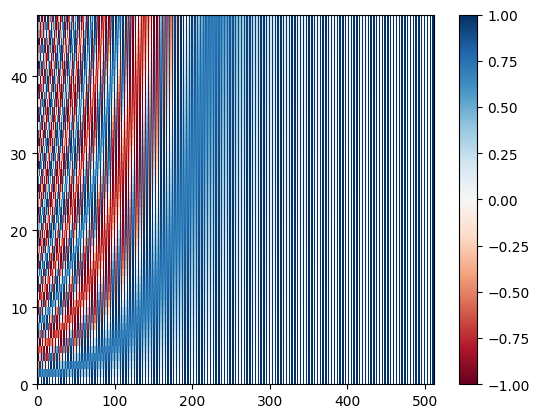

In [10]:
plt.pcolormesh(positional_vector[:, 0], cmap='RdBu')
plt.xlim(0, 512)
plt.colorbar()

In [11]:
class TransformerSeq2Seq(nn.Module):
    def __init__(self,
                 num_enc_layers: int,
                 num_dec_layers: int,
                 emb_dim: int,
                 n_heads: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_ff: int = 512,
                 dropout: float = 0.1,
                 batch_first: bool = False):
        super(TransformerSeq2Seq, self).__init__()
        self.batch_first = batch_first
        self.src_emb = nn.Sequential(TokenEmbedding(src_vocab_size, emb_dim),
                                     PositionalEncoding(emb_dim, dropout=dropout, batch_first=batch_first))
        self.tgt_emb = nn.Sequential(TokenEmbedding(tgt_vocab_size, emb_dim),
                                     PositionalEncoding(emb_dim, dropout=dropout, batch_first=batch_first))
        self.transformer = nn.Transformer(d_model=emb_dim,
                                          nhead=n_heads,
                                          num_encoder_layers=num_enc_layers,
                                          num_decoder_layers=num_dec_layers,
                                          dim_feedforward=dim_ff,
                                          dropout=dropout,
                                          batch_first=batch_first)
        self.regressor = nn.Linear(emb_dim, tgt_vocab_size)

    def forward(self, src: th.Tensor, tgt: th.Tensor,
                src_mask: th.Tensor = None, tgt_mask: th.Tensor = None,
                src_padding_mask: th.Tensor = None,
                tgt_padding_mask: th.Tensor = None,
                memory_key_padding_mask: th.Tensor = None) -> th.Tensor:
        """

        :param src:         [seq_len, bs] or [bs, seq_len]
        :param tgt:         [seq_len, bs] or [bs, seq_len]
        :param src_mask:    [seq_len, bs, seq_len] or [bs, seq_len, seq_len]
        :param tgt_mask:    [seq_len, bs, seq_len] or [bs, seq_len, seq_len]
        :param src_padding_mask:    [seq_len, bs] or [bs, seq_len]
        :param tgt_padding_mask:    [seq_len, bs] or [bs, seq_len]
        :param memory_key_padding_mask: [seq_len, bs] or [bs, seq_len]
        :return:    [seq_len, bs, vocab_size] or [bs, seq_len, vocab_size]
        """
        # src = [seq_len, batch_size] or [batch_size, seq_len]
        # tgt = [seq_len, batch_size] or [batch_size, seq_len]
        src = self.src_emb(src)
        tgt = self.tgt_emb(tgt)
        # [seq_len, bs, emb_dim] or [bs, seq_len, emb_dim]
        output = self.transformer(src, tgt,
                                  src_mask=src_mask, tgt_mask=tgt_mask,
                                  src_key_padding_mask=src_padding_mask,
                                  tgt_key_padding_mask=tgt_padding_mask,
                                  memory_key_padding_mask=memory_key_padding_mask)

        output = self.regressor(output)
        return output

    def encode(self, src: th.Tensor, src_mask: th.Tensor):
        src = self.src_emb(src)
        return self.transformer.encoder(src, src_mask=src_mask)

    def decode(self, tgt: th.Tensor, memory: th.Tensor, tgt_mask: th.Tensor = None, memory_mask: th.Tensor=None):
        tgt = self.tgt_emb(tgt)
        return self.transformer.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)

In [13]:
def look_ahead_mask(seq_len: int, device: th.device = th.device('cpu')):
    # look ahead mask for decoder 1'st layer
    mask = th.triu(th.ones((seq_len, seq_len), device=device), diagonal=1).transpose(0, 1)
    mask = mask.masked_fill(mask == 0, float('-inf'))
    mask = mask.masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src: th.Tensor, tgt: th.Tensor, pad_idx: int = PAD_IDX, batch_first: bool = False):
    """
    src_mask: all True mask, [seq_len, seq_len]
    tgt_mask: look ahead mask, [seq_len, seq_len]
    src_padding_mask: [seq_len, bs] or [bs, seq_len]
    tgt_padding_mask: [seq_len, bs] or [bs, seq_len]
    """
    src_seq_len = src.size(-1 if batch_first else 0)
    tgt_seq_len = tgt.size(-1 if batch_first else 0)

    tgt_mask = look_ahead_mask(tgt_seq_len, device=tgt.device)
    src_mask = th.ones((src_seq_len, src_seq_len), device=src.device)

    src_padding_mask = (src == pad_idx)
    tgt_padding_mask = (tgt == pad_idx)
    if not batch_first:
        src_padding_mask = src_padding_mask.transpose(0, 1)
        tgt_padding_mask = tgt_padding_mask.transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


print(look_ahead_mask(6))
src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(th.tensor([5,6,7,8,1,1]).view(-1, 1).repeat(1, 2),
                                                             th.tensor([1,1,7,8,9,10]).view(-1, 1).repeat(1, 2),
                                                             batch_first=False)
print(f'src_mask:\n{src_mask}')
print(f'tgt_mask:\n{tgt_mask}')
print(f'src_pad_mask:\n{src_pad_mask}')
print(f'tgt_pad_mask:\n{tgt_pad_mask}')

tensor([[-inf, -inf, -inf, -inf, -inf, -inf],
        [0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., -inf]])
src_mask:
tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])
tgt_mask:
tensor([[-inf, -inf, -inf, -inf, -inf, -inf],
        [0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., -inf]])
src_pad_mask:
tensor([[False, False, False, False,  True,  True],
        [False, False, False, False,  True,  True]])
tgt_pad_mask:
tensor([[ True,  True, False, False, False, False],
        [ True,  True, False, False, False, False]])


In [14]:
th.manual_seed(42)

src_vocab_size = len(vocab_transform[SRC_LANG])
tgt_vocab_size = len(vocab_transform[TGT_LANG])
emb_dim = 512
n_heads = 8
num_enc_layers = 3
num_dec_layers = 3
dim_ff = 512
dropout = 0.1

batch_size = 128

model = TransformerSeq2Seq(num_enc_layers=num_enc_layers,
                           num_dec_layers=num_dec_layers,
                           emb_dim=emb_dim,
                           n_heads=n_heads,
                           src_vocab_size=src_vocab_size,
                           tgt_vocab_size=tgt_vocab_size,
                           dim_ff=dim_ff,
                           dropout=dropout)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
# to see the def of Adam, see https://velog.io/@viriditass/%EB%82%B4%EA%B0%80-%EB%B3%B4%EB%A0%A4%EA%B3%A0-%EB%A7%8C%EB%93%A0-Optimizier-%EC%A0%95%EB%A6%AC
optimizer = th.optim.Adam(model.parameters(), lr=0.0001,
                          betas=(0.9, 0.98), eps=1e-9)

In [15]:
from tqdm import tqdm
from torch.utils.data import DataLoader

def train(model: TransformerSeq2Seq,
          dataloader: DataLoader,
          optimizer: th.optim.Optimizer,
          criterion: nn.Module,
          device: th.device = th.device('cpu')):

    model.train()
    epoch_loss = 0
    progress_bar = tqdm(dataloader, total=len(dataloader), postfix='Train: ')
    for i, (src, tgt) in enumerate(progress_bar):
        src = src.to(device)
        tgt = tgt.to(device)

        decoder_input = tgt[:-1, :] # exclude the last token
        src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(src, tgt)
        logits = model(src, decoder_input, src_mask, tgt_mask,
                       src_padding_mask=src_pad_mask,
                       tgt_padding_mask=tgt_pad_mask,
                       memory_key_padding_mask=src_pad_mask)

        optimizer.zero_grad()
        tgt_out = tgt[1:, :].view(-1) # exclude the first token
        output = logits.view(-1, logits.shape[-1])
        loss = criterion(output, tgt_out)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_description(f'loss: {epoch_loss / (i + 1):.3f}')

        if i % 30 == 0:
            th.cuda.empty_cache()

    return epoch_loss / len(dataloader)

def evaluate(model: TransformerSeq2Seq,
             dataloader: DataLoader,
             criterion: nn.Module,
             device: th.device = th.device('cpu')):

    model.eval()
    losses = 0
    progress_bar = tqdm(dataloader, total=len(dataloader), postfix='Eval: ')
    with th.no_grad():
        for i, (src, tgt) in enumerate(progress_bar):
            src = src.to(device)
            tgt = tgt.to(device)

            decoder_input = tgt[:-1, :] # exclude the last token
            src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(src, tgt)
            logits = model(src, decoder_input, src_mask, tgt_mask,
                           src_padding_mask=src_pad_mask,
                           tgt_padding_mask=tgt_pad_mask,
                           memory_key_padding_mask=src_pad_mask)

            tgt_out = tgt[1:, :].view(-1) # exclude the first token
            output = logits.view(-1, logits.shape[-1])
            loss = criterion(output, tgt_out)
            losses += loss.item()
            progress_bar.set_description(f'loss: {losses / (i + 1):.3f}')

    th.cuda.empty_cache()
    return losses / len(dataloader)

In [33]:
import torch as th
th.tensor([1, 2, 0]).fill_(3)

tensor([3, 3, 3])